In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.1


임의의 time series data 생성

In [26]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

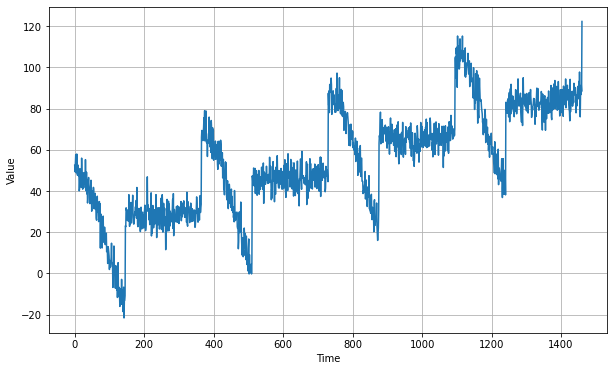

In [27]:
plt.figure(figsize=(10,6))
plot_series(time , series)

In [28]:
# 생성한 데이터를 train 과 valid로 분할
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [29]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [39]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [17]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [40]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
for row in dataset:
    print(row[0], row[1])

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float32, tf.float32)>
tf.Tensor(
[[[ 49.94979   ]
  [ 41.51532   ]
  [ 46.151627  ]
  [ 43.403996  ]
  [ 48.186077  ]
  [ 47.458817  ]
  [ 50.977943  ]
  [ 43.240307  ]
  [ 44.441574  ]
  [ 40.89809   ]
  [ 43.571808  ]
  [ 47.681534  ]
  [ 49.58213   ]
  [ 41.188908  ]
  [ 50.150696  ]
  [ 52.584183  ]
  [ 47.876865  ]
  [ 55.197754  ]
  [ 41.94929   ]
  [ 39.599785  ]]

 [[  8.456475  ]
  [  1.9209299 ]
  [  6.2647085 ]
  [  6.02649   ]
  [  3.1029897 ]
  [  5.6846423 ]
  [  7.8905945 ]
  [ 14.683323  ]
  [  5.5103145 ]
  [  5.3133783 ]
  [  3.0449743 ]
  [ -6.7815113 ]
  [  2.0786734 ]
  [  1.9152563 ]
  [ 13.337309  ]
  [ -0.52937263]
  [  1.3560262 ]
  [ -0.90470564]
  [ -7.1490674 ]
  [  3.8389826 ]]

 [[ 15.136701  ]
  [ 16.036467  ]
  [ 22.487074  ]
  [ 18.91756   ]
  [ 13.98788   ]
  [ 18.565226  ]
  [ 15.846029  ]
  [ 19.565367  ]
  [ 10.573323  ]
  [ 11.806878  ]
  [ 10.846607  ]
  [  4.8520856 ]
  [ 13.013545

tf.Tensor(
[[[ 22.06895  ]
  [ 23.403429 ]
  [ 12.384742 ]
  [ 20.599699 ]
  [ 22.856821 ]
  [ 27.831846 ]
  [ 17.22026  ]
  [ 15.136701 ]
  [ 16.036467 ]
  [ 22.487074 ]
  [ 18.91756  ]
  [ 13.98788  ]
  [ 18.565226 ]
  [ 15.846029 ]
  [ 19.565367 ]
  [ 10.573323 ]
  [ 11.806878 ]
  [ 10.846607 ]
  [  4.8520856]
  [ 13.013545 ]]

 [[ 65.80888  ]
  [ 72.42587  ]
  [ 64.03937  ]
  [ 65.888794 ]
  [ 67.51159  ]
  [ 65.38417  ]
  [ 62.19856  ]
  [ 65.38135  ]
  [ 69.759796 ]
  [ 59.24037  ]
  [ 65.01967  ]
  [ 60.836647 ]
  [ 70.29547  ]
  [ 56.687828 ]
  [ 61.493233 ]
  [ 66.15852  ]
  [ 72.08523  ]
  [ 63.914536 ]
  [ 61.453503 ]
  [ 73.62201  ]]

 [[ 61.493233 ]
  [ 66.15852  ]
  [ 72.08523  ]
  [ 63.914536 ]
  [ 61.453503 ]
  [ 73.62201  ]
  [ 56.963406 ]
  [ 53.19721  ]
  [ 66.379585 ]
  [ 61.65801  ]
  [ 59.0514   ]
  [ 67.68912  ]
  [ 65.356606 ]
  [ 61.307972 ]
  [ 57.718082 ]
  [ 68.47362  ]
  [ 67.35454  ]
  [ 63.60032  ]
  [ 73.322525 ]
  [ 58.73252  ]]

 [[ 41.514812 ]
  [ 40.

tf.Tensor(
[[[ 10.846607  ]
  [  4.8520856 ]
  [ 13.013545  ]
  [ 12.202472  ]
  [ 10.28818   ]
  [  8.456475  ]
  [  1.9209299 ]
  [  6.2647085 ]
  [  6.02649   ]
  [  3.1029897 ]
  [  5.6846423 ]
  [  7.8905945 ]
  [ 14.683323  ]
  [  5.5103145 ]
  [  5.3133783 ]
  [  3.0449743 ]
  [ -6.7815113 ]
  [  2.0786734 ]
  [  1.9152563 ]
  [ 13.337309  ]]

 [[ 41.20642   ]
  [ 52.11075   ]
  [ 46.594894  ]
  [ 44.934753  ]
  [ 52.822556  ]
  [ 44.08511   ]
  [ 40.594     ]
  [ 39.88281   ]
  [ 50.725815  ]
  [ 41.3236    ]
  [ 56.529865  ]
  [ 37.376553  ]
  [ 56.298946  ]
  [ 48.90238   ]
  [ 47.394512  ]
  [ 45.184433  ]
  [ 49.935806  ]
  [ 47.783203  ]
  [ 53.519295  ]
  [ 48.60548   ]]

 [[ 34.92262   ]
  [ 25.599964  ]
  [ 31.317053  ]
  [ 27.594559  ]
  [ 27.541286  ]
  [ 34.147957  ]
  [ 32.805748  ]
  [ 32.771015  ]
  [ 35.255863  ]
  [ 28.8587    ]
  [ 32.188858  ]
  [ 27.253374  ]
  [ 30.451357  ]
  [ 28.205822  ]
  [ 29.367723  ]
  [ 31.884932  ]
  [ 24.84464   ]
  [ 39.42447   ]

tf.Tensor(
[[[ 78.025826  ]
  [ 76.279305  ]
  [ 73.8866    ]
  [ 70.71429   ]
  [ 62.228306  ]
  [ 72.14295   ]
  [ 70.48897   ]
  [ 70.2582    ]
  [ 61.960625  ]
  [ 62.37761   ]
  [ 72.48181   ]
  [ 66.44626   ]
  [ 69.47453   ]
  [ 65.62681   ]
  [ 65.04757   ]
  [ 68.99935   ]
  [ 61.132603  ]
  [ 63.594288  ]
  [ 60.199306  ]
  [ 59.731533  ]]

 [[ 52.584183  ]
  [ 47.876865  ]
  [ 55.197754  ]
  [ 41.94929   ]
  [ 39.599785  ]
  [ 36.93466   ]
  [ 53.314053  ]
  [ 49.111588  ]
  [ 45.56813   ]
  [ 47.25254   ]
  [ 40.23226   ]
  [ 58.09582   ]
  [ 46.520874  ]
  [ 46.429794  ]
  [ 49.520046  ]
  [ 48.304993  ]
  [ 47.02844   ]
  [ 41.966053  ]
  [ 48.28551   ]
  [ 55.34836   ]]

 [[ 28.487524  ]
  [ 35.054302  ]
  [ 20.683037  ]
  [ 33.692867  ]
  [ 27.943205  ]
  [ 22.999773  ]
  [ 30.233395  ]
  [ 28.934015  ]
  [ 24.953756  ]
  [ 28.320253  ]
  [ 26.06135   ]
  [ 28.57245   ]
  [ 31.332735  ]
  [ 35.969654  ]
  [ 21.868246  ]
  [ 38.740505  ]
  [ 18.333178  ]
  [ 27.353228  ]

tf.Tensor(
[[[27.31777   ]
  [26.142935  ]
  [29.688772  ]
  [29.7776    ]
  [22.711872  ]
  [21.861979  ]
  [22.74508   ]
  [11.99279   ]
  [15.311469  ]
  [29.109999  ]
  [29.892042  ]
  [19.817163  ]
  [23.34403   ]
  [21.420355  ]
  [34.665504  ]
  [24.280306  ]
  [17.458702  ]
  [12.741154  ]
  [ 8.912089  ]
  [17.392189  ]]

 [[62.1877    ]
  [55.672768  ]
  [70.70246   ]
  [63.04496   ]
  [69.481316  ]
  [54.984783  ]
  [59.61497   ]
  [62.283337  ]
  [62.12776   ]
  [59.268875  ]
  [64.25051   ]
  [55.40607   ]
  [59.631157  ]
  [60.53453   ]
  [62.086494  ]
  [62.645008  ]
  [53.02789   ]
  [50.536366  ]
  [64.142975  ]
  [58.955788  ]]

 [[46.89202   ]
  [30.474054  ]
  [33.289154  ]
  [32.373535  ]
  [30.853155  ]
  [26.012995  ]
  [31.377792  ]
  [23.712889  ]
  [26.387451  ]
  [25.139708  ]
  [27.971327  ]
  [39.131126  ]
  [18.217827  ]
  [30.982216  ]
  [19.484531  ]
  [25.18608   ]
  [32.98855   ]
  [27.863678  ]
  [22.15246   ]
  [23.963987  ]]

 [[39.131126  ]
  [18.2

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,
                          padding="causal", activation="relu",
                          input_shape=[None, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*200.0)
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 64)          16640     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
_________________________________________________________________
lambda_2 (Lambda)            (None, 1)                 0         
Total params: 41,729
Trainable params: 41,729
Non-trainable params: 0
_________________________________________________________________


In [11]:
# callback 함수에서 자동으로 learning rate를 변경하게끔 만들어 줌.
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8*10**(epoch/20)
)
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer = optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
31/31 [==============================] - 1s 29ms/step - loss: 93.6118 - mae: 94.1116
Epoch 2/100
31/31 [==============================] - 1s 27ms/step - loss: 89.9743 - mae: 90.4740
Epoch 3/100
31/31 [==============================] - 1s 27ms/step - loss: 85.5585 - mae: 86.0581
Epoch 4/100
31/31 [==============================] - 1s 30ms/step - loss: 80.5962 - mae: 81.0960
Epoch 5/100
31/31 [==============================] - 1s 29ms/step - loss: 75.0294 - mae: 75.5294
Epoch 6/100
31/31 [==============================] - 1s 29ms/step - loss: 68.8061 - mae: 69.3058
Epoch 7/100
31/31 [==============================] - 1s 26ms/step - loss: 61.8684 - mae: 62.3681
Epoch 8/100
31/31 [==============================] - 1s 28ms/step - loss: 54.1391 - mae: 54.6391
Epoch 9/100
31/31 [==============================] - 1s 28ms/step - loss: 45.6119 - mae: 46.1109
Epoch 10/100
31/31 [==============================] - 1s 29ms/step - loss: 36.7277 - mae: 37.2260: 0s - loss: 36.8668 - mae: 37

31/31 [==============================] - 1s 28ms/step - loss: 8.6760 - mae: 9.1657: 0s - loss: 8.0771 - mae: 8
Epoch 85/100
31/31 [==============================] - 1s 27ms/step - loss: 5.9237 - mae: 6.4095
Epoch 86/100
31/31 [==============================] - 1s 29ms/step - loss: 8.7364 - mae: 9.2210
Epoch 87/100
31/31 [==============================] - 1s 28ms/step - loss: 8.6804 - mae: 9.1650
Epoch 88/100
31/31 [==============================] - 1s 28ms/step - loss: 13.4862 - mae: 13.9783
Epoch 89/100
31/31 [==============================] - 1s 26ms/step - loss: 8.5564 - mae: 9.0458
Epoch 90/100
31/31 [==============================] - 1s 28ms/step - loss: 16.0419 - mae: 16.5359
Epoch 91/100
31/31 [==============================] - 1s 28ms/step - loss: 9.7090 - mae: 10.1980
Epoch 92/100
31/31 [==============================] - 1s 29ms/step - loss: 9.4296 - mae: 9.9158
Epoch 93/100
31/31 [==============================] - 1s 26ms/step - loss: 10.7006 - mae: 11.1905
Epoch 94/100
31/31

learning rate 와 loss의 그래프를 보면
loss가 가장 작아질때의 lr을 구할 수 있다.
여기선 대략 1*e-5

(1e-08, 0.001, 0.0, 300.0)

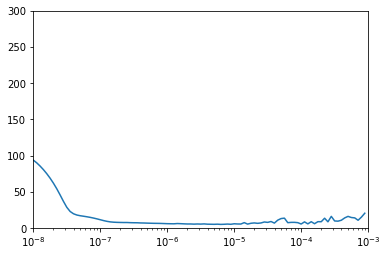

In [12]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [13]:
#최적의 lr을 적용해서 다시 트레이닝
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,
                          padding="causal", activation="relu",
                          input_shape=[None, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*200.0)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=500, verbose=1)

Epoch 1/500
31/31 [==============================] - 1s 28ms/step - loss: 9.7038 - mae: 10.1918
Epoch 2/500
31/31 [==============================] - 1s 27ms/step - loss: 6.8292 - mae: 7.3169
Epoch 3/500
31/31 [==============================] - 1s 24ms/step - loss: 5.8271 - mae: 6.3124: 0s - loss: 5.1566 - ma
Epoch 4/500
31/31 [==============================] - 1s 27ms/step - loss: 6.3281 - mae: 6.8110
Epoch 5/500
31/31 [==============================] - 1s 28ms/step - loss: 7.3508 - mae: 7.8371
Epoch 6/500
31/31 [==============================] - 1s 28ms/step - loss: 5.7151 - mae: 6.1910
Epoch 7/500
31/31 [==============================] - 1s 30ms/step - loss: 5.7740 - mae: 6.2522
Epoch 8/500
31/31 [==============================] - 1s 28ms/step - loss: 6.3707 - mae: 6.8550
Epoch 9/500
31/31 [==============================] - 1s 28ms/step - loss: 5.7562 - mae: 6.2394
Epoch 10/500
31/31 [==============================] - 1s 30ms/step - loss: 5.6188 - mae: 6.0994
Epoch 11/500
31/31 [====

31/31 [==============================] - 1s 28ms/step - loss: 4.6842 - mae: 5.1650
Epoch 86/500
31/31 [==============================] - 1s 28ms/step - loss: 4.6729 - mae: 5.1507
Epoch 87/500
31/31 [==============================] - 1s 23ms/step - loss: 4.2942 - mae: 4.7719
Epoch 88/500
31/31 [==============================] - 1s 28ms/step - loss: 4.3157 - mae: 4.7919
Epoch 89/500
31/31 [==============================] - 1s 28ms/step - loss: 5.4257 - mae: 5.9084
Epoch 90/500
31/31 [==============================] - 1s 28ms/step - loss: 4.2537 - mae: 4.7292: 0s - loss: 4.464
Epoch 91/500
31/31 [==============================] - 1s 22ms/step - loss: 4.3184 - mae: 4.7965
Epoch 92/500
31/31 [==============================] - 1s 28ms/step - loss: 4.9910 - mae: 5.4703
Epoch 93/500
31/31 [==============================] - 1s 28ms/step - loss: 4.7688 - mae: 5.2501
Epoch 94/500
31/31 [==============================] - 1s 28ms/step - loss: 4.3485 - mae: 4.8235
Epoch 95/500
31/31 [===============

31/31 [==============================] - 1s 26ms/step - loss: 4.1780 - mae: 4.6547
Epoch 169/500
31/31 [==============================] - 1s 23ms/step - loss: 4.4570 - mae: 4.9349
Epoch 170/500
31/31 [==============================] - 1s 28ms/step - loss: 3.9718 - mae: 4.4446
Epoch 171/500
31/31 [==============================] - 1s 28ms/step - loss: 4.0766 - mae: 4.5491: 0s - loss: 4.484
Epoch 172/500
31/31 [==============================] - 1s 26ms/step - loss: 3.9142 - mae: 4.3872
Epoch 173/500
31/31 [==============================] - 1s 25ms/step - loss: 4.1584 - mae: 4.6321
Epoch 174/500
31/31 [==============================] - 1s 28ms/step - loss: 4.3103 - mae: 4.7886
Epoch 175/500
31/31 [==============================] - 1s 28ms/step - loss: 4.2943 - mae: 4.7674
Epoch 176/500
31/31 [==============================] - 1s 27ms/step - loss: 4.5305 - mae: 5.0116
Epoch 177/500
31/31 [==============================] - 1s 26ms/step - loss: 4.3752 - mae: 4.8508
Epoch 178/500
31/31 [=====

31/31 [==============================] - 1s 27ms/step - loss: 4.1665 - mae: 4.6413
Epoch 252/500
31/31 [==============================] - 1s 28ms/step - loss: 4.1821 - mae: 4.6561
Epoch 253/500
31/31 [==============================] - 1s 28ms/step - loss: 4.2486 - mae: 4.7245
Epoch 254/500
31/31 [==============================] - 1s 28ms/step - loss: 3.9125 - mae: 4.3887
Epoch 255/500
31/31 [==============================] - 1s 27ms/step - loss: 4.1054 - mae: 4.5810
Epoch 256/500
31/31 [==============================] - 1s 28ms/step - loss: 3.8187 - mae: 4.2909
Epoch 257/500
31/31 [==============================] - 1s 28ms/step - loss: 4.0388 - mae: 4.5152
Epoch 258/500
31/31 [==============================] - 1s 28ms/step - loss: 4.4823 - mae: 4.9589
Epoch 259/500
31/31 [==============================] - 1s 28ms/step - loss: 3.7795 - mae: 4.2504
Epoch 260/500
31/31 [==============================] - 1s 28ms/step - loss: 4.3350 - mae: 4.8075
Epoch 261/500
31/31 [=======================

31/31 [==============================] - 1s 28ms/step - loss: 4.0096 - mae: 4.4841
Epoch 336/500
31/31 [==============================] - 1s 28ms/step - loss: 4.2904 - mae: 4.7663
Epoch 337/500
31/31 [==============================] - 1s 28ms/step - loss: 4.1584 - mae: 4.6334
Epoch 338/500
31/31 [==============================] - 1s 29ms/step - loss: 3.9587 - mae: 4.4328
Epoch 339/500
31/31 [==============================] - 1s 27ms/step - loss: 3.8111 - mae: 4.2849
Epoch 340/500
31/31 [==============================] - 1s 28ms/step - loss: 3.8154 - mae: 4.2877
Epoch 341/500
31/31 [==============================] - 1s 28ms/step - loss: 4.3366 - mae: 4.8084
Epoch 342/500
31/31 [==============================] - 1s 28ms/step - loss: 4.4070 - mae: 4.8852
Epoch 343/500
31/31 [==============================] - 1s 28ms/step - loss: 3.9424 - mae: 4.4148
Epoch 344/500
31/31 [==============================] - 1s 29ms/step - loss: 4.0779 - mae: 4.5577
Epoch 345/500
31/31 [=======================

31/31 [==============================] - 1s 27ms/step - loss: 3.8451 - mae: 4.3152
Epoch 419/500
31/31 [==============================] - 1s 28ms/step - loss: 3.9727 - mae: 4.4444
Epoch 420/500
31/31 [==============================] - 1s 28ms/step - loss: 4.1208 - mae: 4.5949
Epoch 421/500
31/31 [==============================] - 1s 26ms/step - loss: 3.8055 - mae: 4.2813
Epoch 422/500
31/31 [==============================] - 1s 28ms/step - loss: 3.8182 - mae: 4.2867
Epoch 423/500
31/31 [==============================] - 1s 28ms/step - loss: 3.7019 - mae: 4.1705
Epoch 424/500
31/31 [==============================] - 1s 28ms/step - loss: 3.6428 - mae: 4.1082
Epoch 425/500
31/31 [==============================] - 1s 26ms/step - loss: 3.7111 - mae: 4.1825
Epoch 426/500
31/31 [==============================] - 1s 28ms/step - loss: 4.0930 - mae: 4.5722
Epoch 427/500
31/31 [==============================] - 1s 28ms/step - loss: 3.9450 - mae: 4.4146
Epoch 428/500
31/31 [=======================

31/31 [==============================] - 1s 28ms/step - loss: 3.7763 - mae: 4.2429


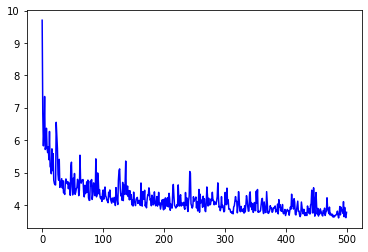

In [14]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

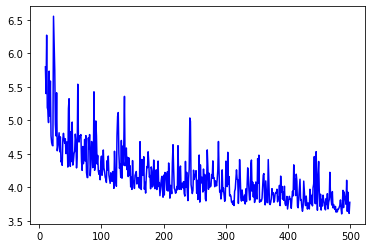

In [15]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

In [24]:
r_forecast = model_forecast(model, series[..., np.newaxis], window_size)
r_forecast = r_forecast[split_time - window_size:-1, -1]

In [25]:
tf.keras.metrics.mean_absolute_error(x_valid, r_forecast).numpy()

6.595284

<Figure size 432x288 with 0 Axes>

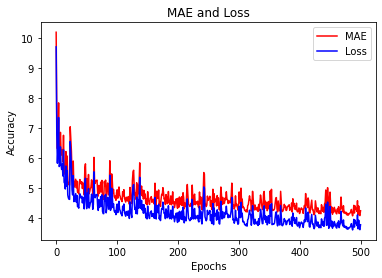

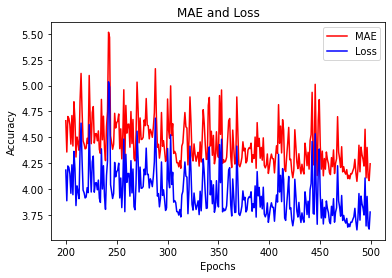

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()